# Home work 1

HSE University  
Master of Data Science  
2023 Spring  
Programming Assignment  

Made by: Akramjon Turakulov  
Group: BASB212  

----


In this project you are required to develop a Natural Language Processing Application for the
text classification problem. The problem can be defined as the process of categorizing text
into a set of predefined groups. The following steps has to be carried out for the project.
1) Prepare a corpus that consists of different kinds of text, like sports, economy, politics and
so on. News web pages can be an important source for this collection. Consider using
crawlers to download the documents. You should decide about the size of the corpus and the
number of categories that you will be working on.
2) There are different methods to perform text classification. Decide about the method you will
prefer. You can pick up more than one method for comparison.
3) Perform experiments on the corpora and analyze the results. You may need to check
concepts like confusion matrix, accuracy, precision, recall, F-Score and so on in order to get
more insight about the results.
4) Prepare a report that gives information about the corpus, methodologies you have used
and the analysis of the results.
Try to perform a comprehensive work. The size of the corpus that you create, the
methodologies you use and the depth of the analysis you perform on the results will be critical
for grading!


### Modules import

First, we have to import all the modules that will be used in the work.

In [1]:
import sys
!{sys.executable} -m pip install pymorphy2
!{sys.executable} -m pip install fake_useragent

from fake_useragent import UserAgent
from concurrent.futures import ThreadPoolExecutor

import requests 
from bs4 import BeautifulSoup 
import re
import time
from datetime import datetime, timedelta

import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn import preprocessing

import numpy as np
import nltk
nltk.download(['averaged_perceptron_tagger_ru', 'stopwords'])
stopwords = nltk.corpus.stopwords.words('russian')
stopwords.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', 'к', 'на'])

from tqdm import tqdm
import pymorphy2

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     C:\Users\turak\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\turak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Next, we need to write a function for parsing the news site http://lenta.ru   
This website is one of the biggest news aggregator in Russia.

### News parsing

This section performs multi-threaded parsing of news from the beginning of 2023. Only those news rubrics that correspond to a certain topic are downloaded.

In [76]:
def news_parsing(date, rubric_list) -> pd.DataFrame: 
    """
    Function for parsing http://lenta.ru/ 
    using fake header
    
    The function takes a date and an array of headers as input.
    The function returns a Pandas DataFrame
    """
    ua = UserAgent() # Create a fake header to make requests look human
    header = {'User-Agent':str(ua.chrome)} # If you don't do this, you can get banned
    start_date = datetime.strptime(date, "%Y/%m/%d").strftime("%Y/%m/%d")
    page_index = 1
    df = pd.DataFrame(columns=['date','news','rubric','href'])
    while True: 
        # create a request with the date and page number
        page_content = BeautifulSoup(requests.get(f"http://lenta.ru/{start_date}/page/{page_index}", headers=header).text, "html5lib")
        # If the page does not exist, then exit the loop
        if "По заданным параметрам материалы не найдены" in page_content.text:
            break

        lis = page_content.find_all("li", {"class": "archive-page__item _news"})
        for el in lis:
            try:
                rubric = el.find("span", {"class": "card-full-news__info-item card-full-news__rubric"}).text
                if rubric not in rubric_list:
                    continue
                href = "http://lenta.ru"+el.find_all("a")[0]["href"]
                article_content = BeautifulSoup(requests.get(href, headers=header).text, "html5lib").find("div", {"class": "topic-body__content"}).get_text()
            except:
                continue
            df = pd.concat([pd.DataFrame([[start_date, article_content, rubric, href]], columns=df.columns), df], ignore_index=True)
        time.sleep(2)
        page_index +=1 # increment the page number value
    
    return df

In [78]:
rubric_list = ['Экономика','Путешествия','Спорт'] # News rubric: 'Economy', 'Travel', 'Sports'
df = pd.DataFrame(columns=['date','news','rubric','href'])
# form an array with all the dates
start = datetime.strptime("2023/01/01", "%Y/%m/%d")
end = datetime.strptime("2023/03/15", "%Y/%m/%d")
date_generated = [start + timedelta(days=x) for x in range(0, (end-start).days)]

processes = []
# MultiThread function execution
with ThreadPoolExecutor(max_workers=8) as executor:
    for day in date_generated:
        processes.append(executor.submit(news_parsing
                                         , day.strftime("%Y/%m/%d")
                                         , rubric_list))
# After all threads are completed, the results must be concatenated
for task in as_completed(processes):
    df = pd.concat([task.result(), df], ignore_index=True)

df

,date,news,rubric,href
0,2023/03/14,Спортивный арбитражный суд (CAS) принял решени...,Спорт,http://lenta.ru/news/2023/03/14/meldoniy/
1,2023/03/14,"Министерство цифрового развития, связи и массо...",Спорт,http://lenta.ru/news/2023/03/14/fan/
2,2023/03/14,Московский «Спартак» на своем поле сыграл внич...,Спорт,http://lenta.ru/news/2023/03/14/spartakural/
3,2023/03/14,В марте власти США и Евросоюза оценят эффектив...,Экономика,http://lenta.ru/news/2023/03/14/nefteprod/
4,2023/03/14,Мастер спорта по самбо и фитнес-тренер Дмитрий...,Спорт,http://lenta.ru/news/2023/03/14/sposobprivesty/
...,...,...,...,...
4901,2023/01/01,"В правительстве Эстонии рассказали, что с 1 ян...",Экономика,http://lenta.ru/news/2023/01/01/gas/
4902,2023/01/01,Издание JB Press обвинило Японию в пополнении ...,Экономика,http://lenta.ru/news/2023/01/01/japan/
4903,2023/01/01,С 1 января 2023 года минимальный размер оплаты...,Экономика,http://lenta.ru/news/2023/01/01/mrot/
4904,2023/01/01,С 2023 года в России вырос прожиточный минимум...,Экономика,http://lenta.ru/news/2023/01/01/minimum/


In [81]:
# Let's save the dataframe as a pickle file  
df.to_pickle("./df_nn2.pkl")  
# df = pd.read_pickle("./df_nn2.pkl")  

A total of 4906 news items were downloaded from 2023/01/01 to 2023/03/15 on topics such as 'Economy', 'Travel', 'Sports'. About 2 hours of machine time were spent on parsing.

### Term frequency / Inverse document frequency (TFIDF)

In this section custom data processing is performed. First, a dictionary and an array with words sorted by frequency of occurrence in the news are generated. Then text vectorization is performed, reflecting the importance of the word in the document, not only the frequency of its occurrence.

In [82]:
morph = pymorphy2.MorphAnalyzer()
imp_POS = ['ADJF', 'ADJS', 'NOUN', 'VERB', 'PRTF', 'PRTS', 'GRND']

def getMostFrequentWordsFiltered(text):
    """
    Function for getting a wordlist for each news item
    and to get a sorted array of the most 
    most frequently occurring words
    
    The function takes as input a string
    The function returns the dictionary, an array
    """
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        pv = morph.parse(t)
        if pv[0].tag.POS in imp_POS and pv[0].normal_form != 'быть':
            words.append(pv[0].normal_form)
    text = ' '.join(words)
    
    counter=CountVectorizer(ngram_range=(1,2), stop_words=stopwords, token_pattern=r'[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+')
    res=counter.fit_transform([text])
    frq = sorted([(i, int(res[0][0,i])) for i in range(res[0].shape[1])], key = lambda x: x[1], reverse = True)[:5]
    vocab = {w:res[0,i] for w,i in counter.vocabulary_.items()}
    return [[w for w, n in counter.vocabulary_.items() if n==i][0] for i, f in frq], vocab

In [83]:
# let's add two columns to the dataframe
freqwords = []
vocabs = []
for i in tqdm(range(df.shape[0])):
    fw, v = getMostFrequentWordsFiltered(df.news.iloc[i])
    freqwords.append(fw)
    vocabs.append(v)
    
df['Vocabular'] = vocabs
df['Freq Words'] = freqwords
df.head(10)

100%|██████████████████████████████████████████████████████████████████████████████| 4906/4906 [06:13<00:00, 13.12it/s]


,date,news,rubric,href,Vocabular,Freq Words
0,2023/03/14,Спортивный арбитражный суд (CAS) принял решени...,Спорт,http://lenta.ru/news/2023/03/14/meldoniy/,"{'спортивный': 1, 'арбитражный': 1, 'суд': 2, ...","[год, дисквалификация, запретить, спортсмен, в..."
1,2023/03/14,"Министерство цифрового развития, связи и массо...",Спорт,http://lenta.ru/news/2023/03/14/fan/,"{'министерство': 1, 'цифровой': 1, 'развитие':...","[карта, болельщик, госуслуга, биометрия, диста..."
2,2023/03/14,Московский «Спартак» на своем поле сыграл внич...,Спорт,http://lenta.ru/news/2023/03/14/spartakural/,"{'московский': 2, 'спартак': 1, 'свой': 1, 'по...","[кубок, кубок россия, путь, россия, финал]"
3,2023/03/14,В марте власти США и Евросоюза оценят эффектив...,Экономика,http://lenta.ru/news/2023/03/14/nefteprod/,"{'март': 1, 'власть': 1, 'сша': 4, 'евросоюз':...","[сша, цена, доллар, евросоюз, потолок]"
4,2023/03/14,Мастер спорта по самбо и фитнес-тренер Дмитрий...,Спорт,http://lenta.ru/news/2023/03/14/sposobprivesty/,"{'мастер': 1, 'спорт': 1, 'самбо': 1, 'фитнес-...","[бег, заявить, нагулин, пробежка, анаболический]"
5,2023/03/14,Компания Life at Sea Cruises открыла бронирова...,Путешествия,http://lenta.ru/news/2023/03/14/cruise/,"{'компания': 2, 'открыть': 1, 'бронирование': ...","[год, пассажир, путешествие, человек, борт]"
6,2023/03/14,"В Великобритании пассажирский самолет, заходящ...",Путешествия,http://lenta.ru/news/2023/03/14/samoletus/,"{'великобритания': 3, 'пассажирский': 1, 'само...","[ветер, великобритания, сильный, встречный, вс..."
7,2023/03/14,Международная федерация футбола (ФИФА) утверди...,Спорт,http://lenta.ru/news/2023/03/14/newformat/,"{'международный': 1, 'федерация': 1, 'футбол':...","[команда, мир, чемпионат, чемпионат мир, каждый]"
8,2023/03/14,Московский «Локомотив» на выезде проиграл толь...,Спорт,http://lenta.ru/news/2023/03/14/cuprussia/,"{'московский': 1, 'локомотив': 2, 'выезд': 1, ...","[акрон, кубок, кубок россия, локомотив, матч]"
9,2023/03/14,Российский Минфин не предлагал и не планирует ...,Экономика,http://lenta.ru/news/2023/03/14/nonono/,"{'российский': 1, 'минфин': 3, 'предлагать': 2...","[минфин, облигация, ведомство, время, настоящий]"


In [84]:
def normalizePymorphy2(text):
    """
    Function for converting words to normal form
    
    The function takes a string as input
    Returns an array
    """
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        pv = morph.parse(t)
        words.append(pv[0].normal_form)
    return words

In [86]:
# Let's perform Tfid vectorization using Russian stop words
tfc = TfidfVectorizer(ngram_range=(1,2), stop_words=stopwords)
tfr = tfc.fit_transform([' '.join(normalizePymorphy2(n)) for n in df.news])

freqwords = []
for i in tqdm(range(df.shape[0])):

    tfs = [(k,tfr[i][0, tfc.vocabulary_.get(k)]) for k in df.Vocabular.iloc[i] 
         if k in tfc.vocabulary_.keys()]
    fw = [w for w, f in sorted(tfs, key = lambda x: x[1], reverse = True)[:10]]
    txt = ' '.join(fw)
    freqwords.append(txt)

df['Tfidf'] = freqwords
df.head(10)

100%|██████████████████████████████████████████████████████████████████████████████| 4906/4906 [01:28<00:00, 55.35it/s]


,date,news,rubric,href,Vocabular,Freq Words,Tfidf
0,2023/03/14,Спортивный арбитражный суд (CAS) принял решени...,Спорт,http://lenta.ru/news/2023/03/14/meldoniy/,"{'спортивный': 1, 'арбитражный': 1, 'суд': 2, ...","[год, дисквалификация, запретить, спортсмен, в...",дисквалификация верняева верняев мельдонья зап...
1,2023/03/14,"Министерство цифрового развития, связи и массо...",Спорт,http://lenta.ru/news/2023/03/14/fan/,"{'министерство': 1, 'цифровой': 1, 'развитие':...","[карта, болельщик, госуслуга, биометрия, диста...",госуслуга карта карта болельщик биометрия боле...
2,2023/03/14,Московский «Спартак» на своем поле сыграл внич...,Спорт,http://lenta.ru/news/2023/03/14/spartakural/,"{'московский': 2, 'спартак': 1, 'свой': 1, 'по...","[кубок, кубок россия, путь, россия, финал]",кубок россия финал путь путь финал кубок желез...
3,2023/03/14,В марте власти США и Евросоюза оценят эффектив...,Экономика,http://lenta.ru/news/2023/03/14/nefteprod/,"{'март': 1, 'власть': 1, 'сша': 4, 'евросоюз':...","[сша, цена, доллар, евросоюз, потолок]",харрис потолок цена установить потолок потолок...
4,2023/03/14,Мастер спорта по самбо и фитнес-тренер Дмитрий...,Спорт,http://lenta.ru/news/2023/03/14/sposobprivesty/,"{'мастер': 1, 'спорт': 1, 'самбо': 1, 'фитнес-...","[бег, заявить, нагулин, пробежка, анаболический]",нагулин пробежка бег риамо спорт самбо дмитрий...
5,2023/03/14,Компания Life at Sea Cruises открыла бронирова...,Путешествия,http://lenta.ru/news/2023/03/14/cruise/,"{'компания': 2, 'открыть': 1, 'бронирование': ...","[год, пассажир, путешествие, человек, борт]",каюта мечта пассажир зал путешествие лайнер бо...
6,2023/03/14,"В Великобритании пассажирский самолет, заходящ...",Путешествия,http://lenta.ru/news/2023/03/14/samoletus/,"{'великобритания': 3, 'пассажирский': 1, 'само...","[ветер, великобритания, сильный, встречный, вс...",ветер встречный ветер встречный великобритания...
7,2023/03/14,Международная федерация футбола (ФИФА) утверди...,Спорт,http://lenta.ru/news/2023/03/14/newformat/,"{'международный': 1, 'федерация': 1, 'футбол':...","[команда, мир, чемпионат, чемпионат мир, каждый]",команда каждый чемпионат мир фифа сборный кома...
8,2023/03/14,Московский «Локомотив» на выезде проиграл толь...,Спорт,http://lenta.ru/news/2023/03/14/cuprussia/,"{'московский': 1, 'локомотив': 2, 'выезд': 1, ...","[акрон, кубок, кубок россия, локомотив, матч]",акрон тольяттинский регион кубок финал путь пу...
9,2023/03/14,Российский Минфин не предлагал и не планирует ...,Экономика,http://lenta.ru/news/2023/03/14/nonono/,"{'российский': 1, 'минфин': 3, 'предлагать': 2...","[минфин, облигация, ведомство, время, настоящий]",патриотический облигация минфин минфин предлаг...


### Clusterization

Let's perform clustering in order to understand the distribution of data and see how well the clusters are separated

In [89]:
crit = []
sil = []
ari = []

for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(tfr)
    cluster_labels = kmeans.predict(tfr)
    crit.append(np.sqrt(kmeans.inertia_))
    sil.append(silhouette_score(tfr, cluster_labels))
    ari.append(adjusted_rand_score(df['rubric'], cluster_labels))

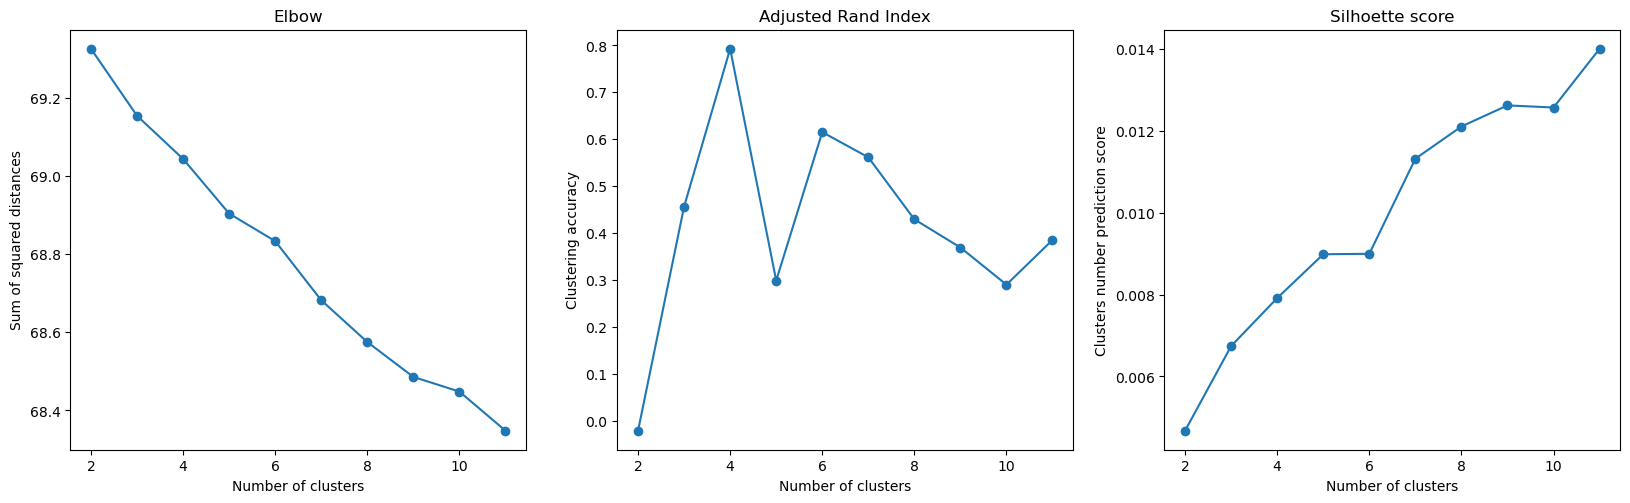

In [90]:
plt.rcParams['figure.figsize'] = (20, 12)

ax1 = plt.subplot(234)
ax1.plot(range(2,12), crit, marker='o')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Sum of squared distances')
ax1.set_title('Elbow')

ax2 = plt.subplot(235)
ax2.plot(range(2,12), ari, marker='o')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Clustering accuracy')
ax2.set_title('Adjusted Rand Index')

ax3 = plt.subplot(236)
ax3.plot(range(2,12), sil, marker='o')
ax3.set_xlabel('Number of clusters')
ax3.set_ylabel('Clusters number prediction score')
ax3.set_title('Silhoette score')

plt.show()

From the elbow and silhoette graphs it is impossible to guess the number of clusters

In [91]:
print(df.groupby('rubric')['news'].nunique())

rubric
Путешествия     983
Спорт          1530
Экономика      2381
Name: news, dtype: int64


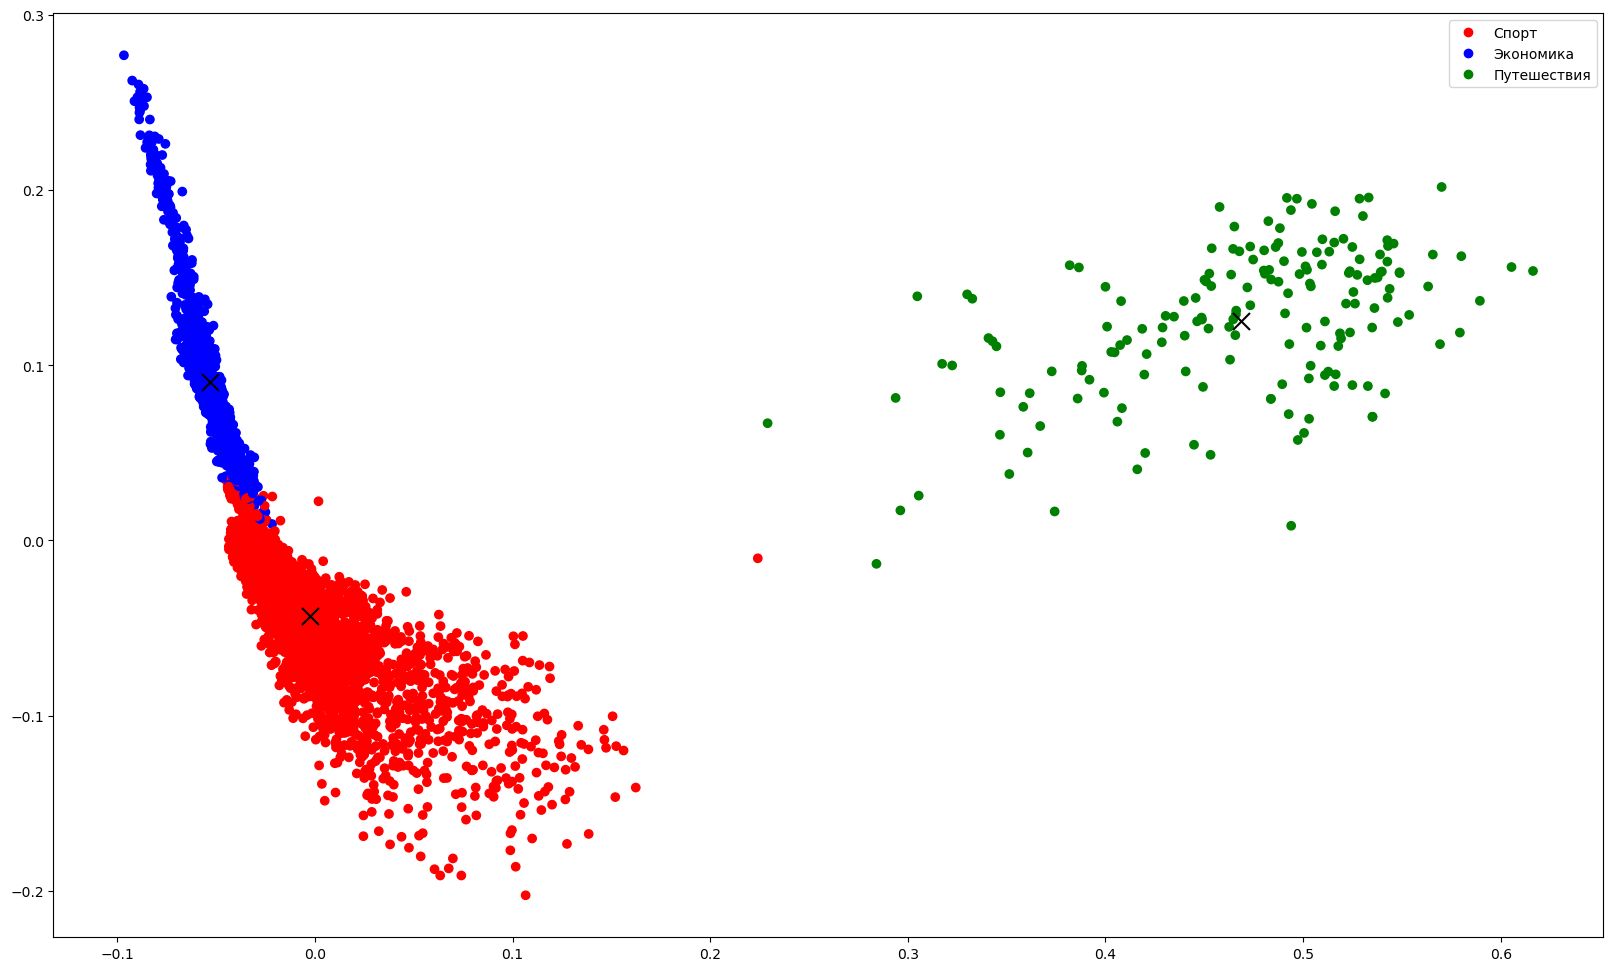

In [98]:
kmeans1 = KMeans(n_clusters=3, random_state=1).fit(tfr)
# Reduce dimensionality to 2D
pca = PCA(n_components=3, random_state=1)
reduced_features = pca.fit_transform(tfr.toarray())

# Reduce cluster centers to 2D
reduced_cluster_centers = pca.transform(kmeans1.cluster_centers_)

classes = ['Спорт', 'Экономика', 'Путешествия']
colours = ListedColormap(['r','b','g'])
scatter = plt.scatter(reduced_features[:,0], reduced_features[:,1], c=kmeans1.predict(tfr), cmap=colours)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='black')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

According to this cluster scatter plot, we can say with certainty that there are only 3 clusters and they are well separated. The topic of the news related to travel is very different from the news about sports or the economy. Whereas news about sports and economics have a common basis.  

### RNN model on raw news

Let's create an RNN model for Multi-Class news Classification using keras standart tools

In [116]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import keras.backend as K

Vectorize news, by turning each text into either a sequence of integers or into a vector. Here I use keras standart tools

In [152]:
keras_tokenizer = Tokenizer(num_words=250
                            , filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
                            , lower=True)
keras_tokenizer.fit_on_texts(df['news'].values)
word_index = keras_tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

Found 75742 unique tokens.


Truncate and pad the input sequences so that they are all in the same length for modeling

In [153]:
X = keras_tokenizer.texts_to_sequences(df['news'].values)
X = pad_sequences(X, maxlen=250)
print('News tensor shape:', X.shape)

News tensor shape: (4906, 250)


In [154]:
Y = pd.get_dummies(df['rubric']).values
print('Target tensor shape:', Y.shape)

Target tensor shape: (4906, 3)


In [155]:
# Here I split dataset into train and test subsets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

In [157]:
# custom metrics
def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

model = Sequential()
model.add(Embedding(50000, 100, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy'
              , optimizer='adam'
              , metrics=['accuracy', precision, recall])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_8 (LSTM)               (None, 100)               80400     
                                                                 
 dense_8 (Dense)             (None, 3)                 303       
                                                                 
Total params: 5,080,703
Trainable params: 5,080,703
Non-trainable params: 0
_________________________________________________________________
None


In [158]:
keras_model_v1 = model.fit(  X_train
                            , Y_train
                            , epochs=5
                            , batch_size=64
                            , validation_split=0.1
                            , callbacks=[EarlyStopping(monitor='val_loss'
                                                       , patience=3
                                                       , min_delta=0.0001)]
                           )

Epoch 1/5
56/56 [==============================] - 41s 680ms/step - loss: 0.8608 - accuracy: 0.6055 - precision: 0.6134 - recall: 0.3585 - val_loss: 0.5022 - val_accuracy: 0.7913 - val_precision: 0.8403 - val_recall: 0.7334
Epoch 2/5
56/56 [==============================] - 37s 668ms/step - loss: 0.4447 - accuracy: 0.8287 - precision: 0.8965 - recall: 0.7480 - val_loss: 0.3000 - val_accuracy: 0.8982 - val_precision: 0.9172 - val_recall: 0.8566
Epoch 3/5
56/56 [==============================] - 37s 662ms/step - loss: 0.2832 - accuracy: 0.9012 - precision: 0.9190 - recall: 0.8734 - val_loss: 0.2235 - val_accuracy: 0.9338 - val_precision: 0.9138 - val_recall: 0.9035
Epoch 4/5
56/56 [==============================] - 38s 672ms/step - loss: 0.2205 - accuracy: 0.9258 - precision: 0.9364 - recall: 0.9177 - val_loss: 0.2226 - val_accuracy: 0.9338 - val_precision: 0.9405 - val_recall: 0.9172
Epoch 5/5
56/56 [==============================] - 39s 696ms/step - loss: 0.1760 - accuracy: 0.9391 - pr

After training the model, it is necessary to create a visual representation of the quality of the model

In [160]:
metrics = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}\n  Precision: {:0.3f}\n  Recall: {:0.3f}'.format(metrics[0],metrics[1],metrics[2],metrics[3]))

31/31 [==============================] - 3s 88ms/step - loss: 0.1796 - accuracy: 0.9318 - precision: 0.9427 - recall: 0.9260
Test set
  Loss: 0.180
  Accuracy: 0.932
  Precision: 0.943
  Recall: 0.926


(0.32974457144737246, 1.0)

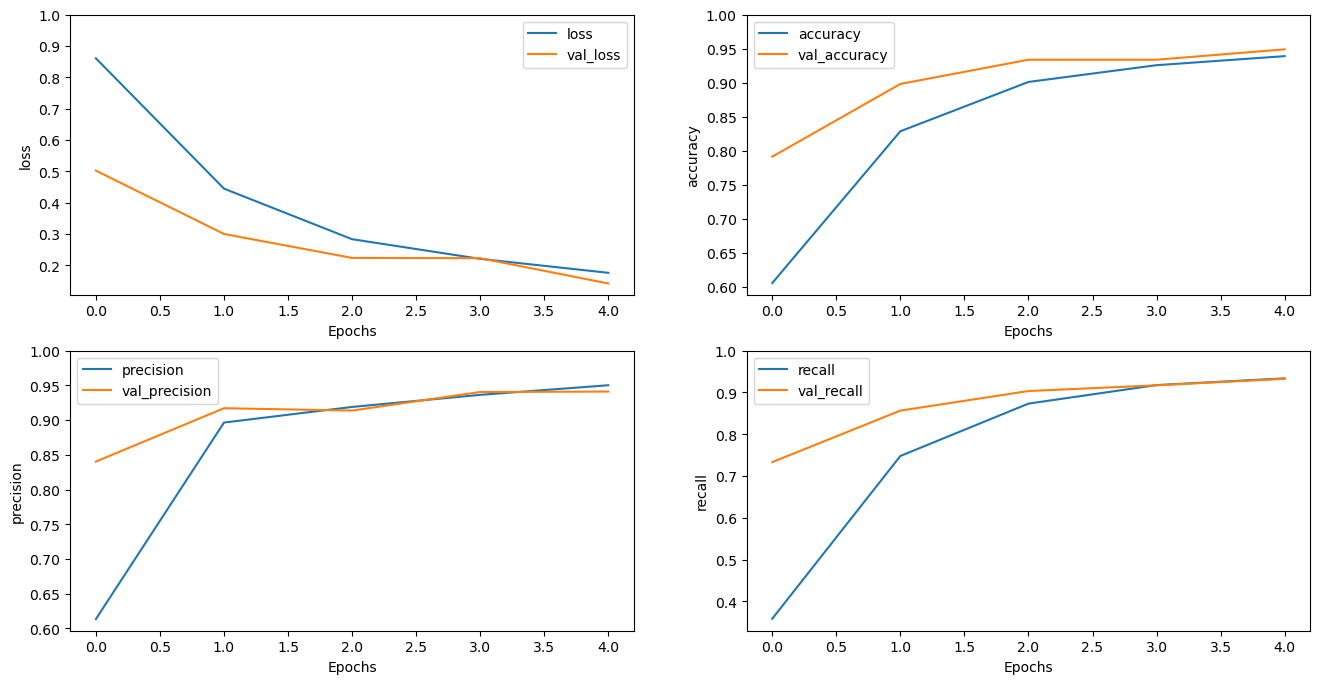

In [180]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plot_graphs(keras_model_v1, 'loss')
plt.ylim(None, 1)
plt.subplot(2, 2, 2)
plot_graphs(keras_model_v1, 'accuracy')
plt.ylim(None, 1)
plt.subplot(2, 2, 3)
plot_graphs(keras_model_v1, 'precision')
plt.ylim(None, 1)
plt.subplot(2, 2, 4)
plot_graphs(keras_model_v1, 'recall')
plt.ylim(None, 1)

According to the results, we can say that the quality of the model is quiet good.   
Test set accuracy is equal to 0.932  
Test set precision is equal to 0.943  
Test set recall is equal to 0.926  

### RNN model on TfidfVectorizer dataframe

Earlier in Term frequency / Inverse document frequency (TFIDF) section the custom data processing was performed. 
After creating an RNN model based on the processed text by Keras tools, it is necessary to check the result on the data with custom news processing. The point is to use TfidfVectorizer data.

In [163]:
keras_tokenizer = Tokenizer(num_words=250
                            , filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
                            , lower=True)
keras_tokenizer.fit_on_texts(df['Tfidf'].values)
word_index = keras_tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

Found 10480 unique tokens.


In [164]:
X = keras_tokenizer.texts_to_sequences(df['Tfidf'].values)
X = pad_sequences(X, maxlen=250)
print('News tensor shape:', X.shape)

News tensor shape: (4906, 250)


In [165]:
Y = pd.get_dummies(df['rubric']).values
print('Target tensor shape:', Y.shape)

Target tensor shape: (4906, 3)


In [166]:
# Here I split dataset into train and test subsets again
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [167]:
model = Sequential()
model.add(Embedding(50000, 100, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy'
              , optimizer='adam'
              , metrics=['accuracy', precision, recall])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_8 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dense_9 (Dense)             (None, 3)                 303       
                                                                 
Total params: 5,080,703
Trainable params: 5,080,703
Non-trainable params: 0
_________________________________________________________________
None


In [168]:
keras_model_v2 = model.fit(  X_train
                            , Y_train
                            , epochs=5
                            , batch_size=64
                            , validation_split=0.1
                            , callbacks=[EarlyStopping(monitor='val_loss'
                                                       , patience=3
                                                       , min_delta=0.0001)]
                           )

Epoch 1/5
56/56 [==============================] - 42s 690ms/step - loss: 0.8783 - accuracy: 0.6010 - precision: 0.6821 - recall: 0.3569 - val_loss: 0.5219 - val_accuracy: 0.8626 - val_precision: 0.9589 - val_recall: 0.6352
Epoch 2/5
56/56 [==============================] - 38s 682ms/step - loss: 0.3596 - accuracy: 0.8816 - precision: 0.9410 - recall: 0.7936 - val_loss: 0.2398 - val_accuracy: 0.9109 - val_precision: 0.9376 - val_recall: 0.8792
Epoch 3/5
56/56 [==============================] - 38s 683ms/step - loss: 0.2359 - accuracy: 0.9094 - precision: 0.9473 - recall: 0.8776 - val_loss: 0.2021 - val_accuracy: 0.9237 - val_precision: 0.9615 - val_recall: 0.9040
Epoch 4/5
56/56 [==============================] - 38s 676ms/step - loss: 0.2070 - accuracy: 0.9139 - precision: 0.9438 - recall: 0.8865 - val_loss: 0.2084 - val_accuracy: 0.9135 - val_precision: 0.9459 - val_recall: 0.8926
Epoch 5/5
56/56 [==============================] - 38s 672ms/step - loss: 0.1991 - accuracy: 0.9165 - pr

In [169]:
metrics = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}\n  Precision: {:0.3f}\n  Recall: {:0.3f}'.format(metrics[0],metrics[1],metrics[2],metrics[3]))

31/31 [==============================] - 2s 80ms/step - loss: 0.2910 - accuracy: 0.8921 - precision: 0.9228 - recall: 0.8646
Test set
  Loss: 0.291
  Accuracy: 0.892
  Precision: 0.923
  Recall: 0.865


(0.32955938428640363, 1.0)

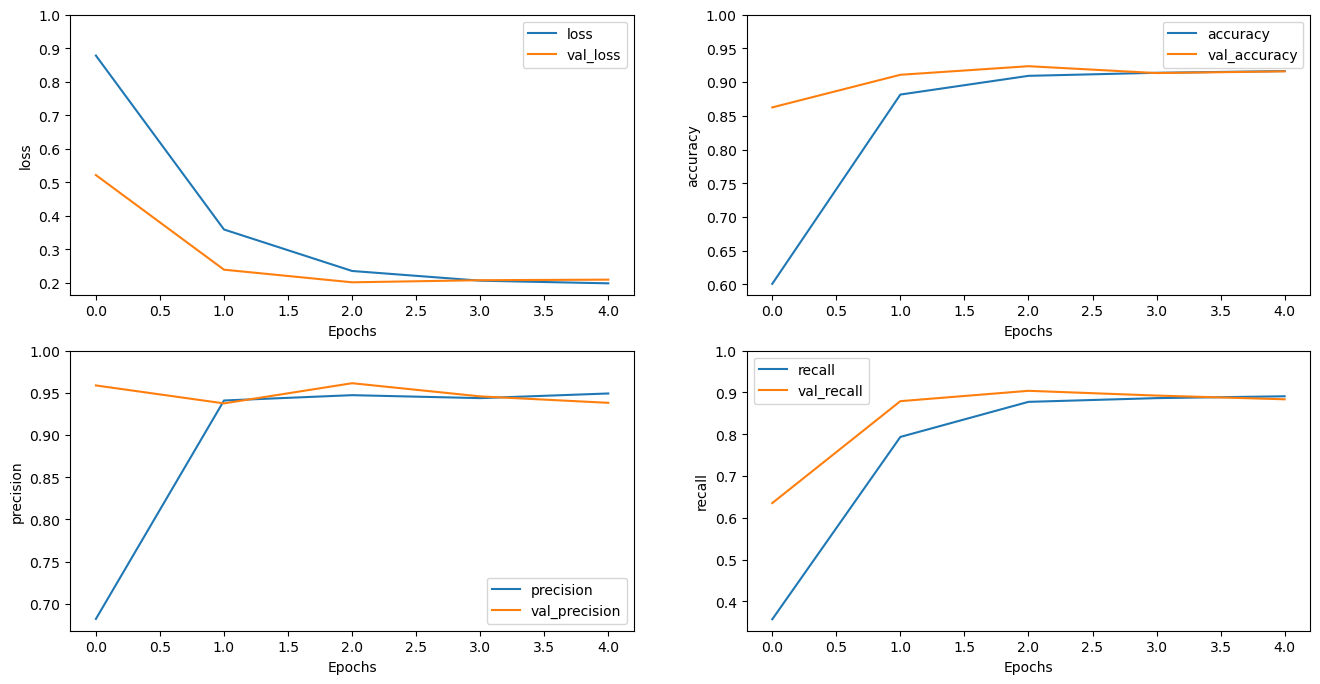

In [181]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plot_graphs(keras_model_v2, 'loss')
plt.ylim(None, 1)
plt.subplot(2, 2, 2)
plot_graphs(keras_model_v2, 'accuracy')
plt.ylim(None, 1)
plt.subplot(2, 2, 3)
plot_graphs(keras_model_v2, 'precision')
plt.ylim(None, 1)
plt.subplot(2, 2, 4)
plot_graphs(keras_model_v2, 'recall')
plt.ylim(None, 1)

You can see that with custom data processing, the accuracy of the RNN model slightly decreases. In the custom processing part, important features have apparently been lost.   
Test set accuracy is equal to 0.892  
Test set precision is equal to 0.923   
Test set recall is equal to 0.865  